# ColPali: how to get similarity maps? 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

[[ColPali Training Repo]](https://github.com/illuin-tech/colpali)
[[ViDoRe Benchmark Repo]](https://github.com/illuin-tech/vidore-benchmark)

## Introduction

> With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from PaliGemma-3B to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.
>
> ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColPali’s strong OCR capabilities and chart understanding.

The following notebook guide you through how to generate your own similarity maps. You can run it on Colab or locally (tested on a M2 Pro Mac).

## Login to a HuggingFace account that has accepted the term conditions to use the PaliGemma3B checkpoints

In [ ]:
!pip install -q huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

## Imports

In [ ]:
!pip install -q "vidore-benchmark[interpretability]>=3.2.0,<4.0.0"

In [ ]:
from dataclasses import asdict
from pathlib import Path
from typing import cast

import torch
from einops import rearrange
from peft import LoraConfig, PeftConfig
from PIL import Image
from vidore_benchmark.interpretability.colpali_processor import ColPaliProcessor
from vidore_benchmark.interpretability.plot_utils import plot_similarity_heatmap
from vidore_benchmark.interpretability.torch_utils import normalize_similarity_map_per_query_token
from vidore_benchmark.interpretability.vit_configs import VIT_CONFIG
from vidore_benchmark.models.colpali_model import ColPali
from vidore_benchmark.utils.image_utils import scale_image
from vidore_benchmark.utils.torch_utils import get_torch_device

device = get_torch_device()

## Load model + adapter + custom processor

In [ ]:
model_path = "google/paligemma-3b-mix-448"
lora_path = "vidore/colpali"

# Load the model and LORA adapter
model = cast(ColPali, ColPali.from_pretrained(model_path, device_map=device))
vit_config = VIT_CONFIG[model_path]

peft_config = cast(LoraConfig, PeftConfig.from_pretrained(lora_path))

# Load the Lora adapter into the model
# Note:`add_adapter` is used to create a new adapter while `load_adapter` is used to load an existing adapter
model.load_adapter(lora_path, adapter_name="colpali", device_map=device)
if model.active_adapters() != ["colpali"]:
    raise ValueError(f"Incorrect adapters loaded: {model.active_adapters()}")
print(f"Loaded model from {model_path} and LORA from {lora_path}")

# Load the processor
processor = ColPaliProcessor.from_pretrained(model_path)
print("Loaded custom processor")

## Load image from filepaths

⚠️ First, upload your image in the Google Colab environment, then replace the following variable values with your own.

In [ ]:
# TODO: Replace the following values with your own!
filepath = Path("shift_kazakhstan.jpg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"
assert filepath.is_file(), "Cannot find the image file."
image = Image.open(filepath)

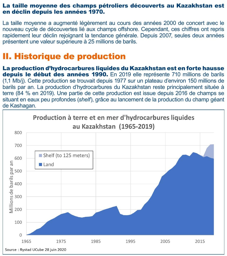

In [ ]:
# Resize the image to square
input_image_square = image.resize((vit_config.resolution, vit_config.resolution))

scale_image(image, 256)

## Process text and image separately

In [ ]:
input_text_processed = processor.process_text(query).to(device)
input_image_processed = processor.process_image(image, add_special_prompt=True).to(device)

## Embed text and image separately

In [ ]:
with torch.no_grad():
    output_text = model.forward(**asdict(input_text_processed))  # type: ignore

with torch.no_grad():
    output_image = model.forward(**asdict(input_image_processed))  # type: ignore

# Remove the memory tokens
output_image = output_image[:, : processor.processor.image_seq_length, :]  # (1, n_patch_x * n_patch_y, hidden_dim)

output_image = rearrange(
    output_image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
)

output_image.shape

torch.Size([1, 32, 32, 128])

## Per-token attention map

In [ ]:
# Tensor shapes:
# output_text: (batch_size, n_tokens, hidden_size)
# output_image: (batch_size, n_patch_x, n_patch_y, hidden_size)
# attention_map: (batch_size, n_tokens, n_patch_x, n_patch_y)

attention_map = torch.einsum("bnk,bijk->bnij", output_text, output_image)

# Normalize the attention map (all values should be between 0 and 1)
attention_map_normalized = normalize_similarity_map_per_query_token(attention_map)

attention_map_normalized.shape

torch.Size([1, 19, 32, 32])

In [ ]:
# Use this cell output to choose a token
{idx: val for idx, val in enumerate(processor.tokenizer.tokenize(query))}

{0: 'Quelle',
 1: '▁partie',
 2: '▁de',
 3: '▁la',
 4: '▁production',
 5: '▁p',
 6: 'étro',
 7: 'lière',
 8: '▁du',
 9: '▁Kazakhstan',
 10: '▁provi',
 11: 'ent',
 12: '▁de',
 13: '▁champs',
 14: '▁en',
 15: '▁mer',
 16: '▁?'}

In [ ]:
# Choose a token (add 1 to the index to take the <bos> token into account):
token_idx = 9 + 1  # shift graph -> <_Kazakhstan>

print(f"Token: {processor.batch_decode(input_text_processed.input_ids[:, token_idx])}")

# Retrieve the attention map for the chosen token
current_attention_map = attention_map_normalized[0, token_idx, :, :]

current_attention_map.shape

Token: [' Kazakhstan']


torch.Size([32, 32])

## Experiment with heatmaps

In [ ]:
attention_map_image = Image.fromarray(
    (attention_map_normalized[0, token_idx, :, :].cpu().numpy() * 255).astype("uint8")
).resize(input_image_square.size, Image.Resampling.BICUBIC)

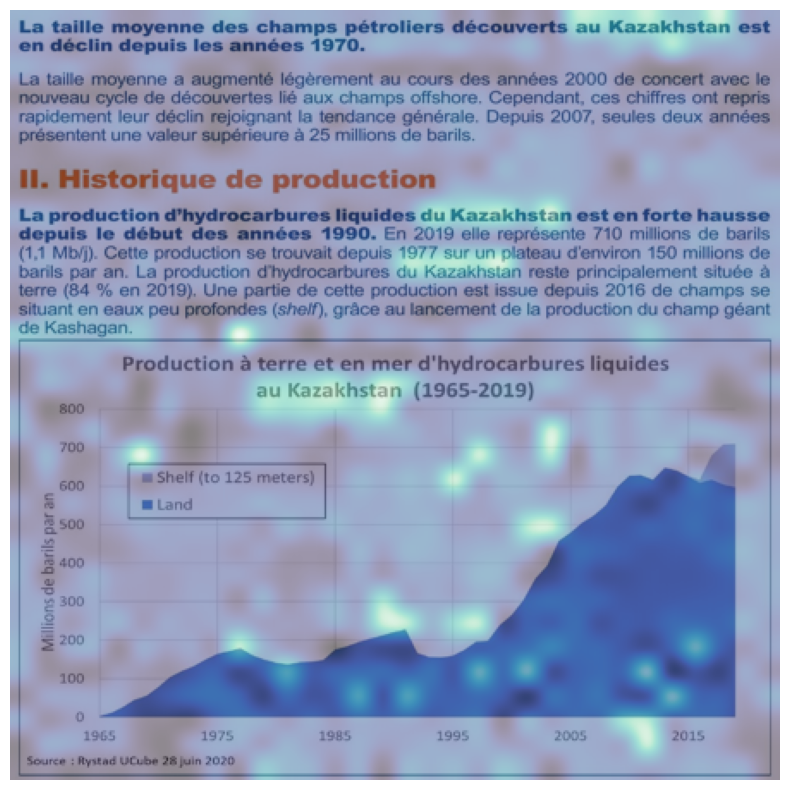

In [ ]:
fig, ax = plot_similarity_heatmap(
    input_image_square,
    patch_size=vit_config.patch_size,
    image_resolution=vit_config.resolution,
    similarity_map=attention_map_normalized[0, token_idx, :, :],
)